## StateGraph with Proper State Management

In [1]:
from typing import TypedDict, Annotated, Literal
from operator import add
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

In [2]:
class AgentState(TypedDict):
    messages: Annotated[list, add]
    current_step: str
    iteration: Annotated[int, add]
    max_iterations: int
    error: str | None

In [3]:
llm = ChatOllama(model="llama3.2", temperature=0.5)

In [27]:
# nodes
def process_input(state: AgentState) -> dict:
    """Process user input and generate initial response"""
    try:
        response = llm.invoke(state["messages"])
        
        return {
            "messages": [response],  # Will be appended via 'add' reducer
            "current_step": "processed",
            "iteration": 1  # Will be added to existing value
        }
    except Exception as e:
        return {
            "error": str(e),
            "current_step": "error"
        }
    
def review_output(state: AgentState) -> dict:
    """Review the output for quality"""
    last_message = state["messages"][-1].content
    
    review_prompt = """Review this response for accuracy and completeness.

Response:
{response}

Rate from 1-10 and provide brief feedback.
"""
    
    review = llm.invoke([
        SystemMessage(content="You are a strict technical reviewer."),
        HumanMessage(
            content=review_prompt.format(response=last_message)
        )
    ])
    
    return {
        "messages": [SystemMessage(content=f"Review: {review.content}")],
        "current_step": "reviewed"
    }

def improve_output(state: AgentState) -> dict:
    """Improve based on review"""
    # Get original question and review
    original_q = state["messages"][0].content
    review = state["messages"][-1].content
    
    improve_prompt = """Original question:
{question}

Review feedback:
{review}

Provide an improved response addressing the feedback.
"""
    
    improved = llm.invoke([
        SystemMessage(content="You are an expert educator."),
        HumanMessage(
            content=improve_prompt.format(
                question=original_q,
                review=review
            )
        )
    ])
    
    return {
        "messages": [improved],
        "iteration": 1
    }

def should_continue(state: AgentState) -> Literal["improve", "review", "end"]:
    """Decide next step based on state"""
    
    # Check for errors
    if state.get("error"):
        return "end"
    
    # Check iteration limit
    if state["iteration"] >= state["max_iterations"]:
        return "end"
    
    # Route based on current step
    if state["current_step"] == "processed":
        return "review"
    elif state["current_step"] == "reviewed":
        # Simple logic: improve if iteration < max
        if state["iteration"] < state["max_iterations"]:
            return "improve"
        return "end"
    
    return "end"

In [28]:
# Step 5: Build the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("process", process_input)
workflow.add_node("review", review_output)
workflow.add_node("improve", improve_output)

# Set entry point
workflow.set_entry_point("process")

# Add conditional edges
workflow.add_conditional_edges(
    "process",
    should_continue,
    {
        "review": "review",
        "end": END
    }
)

workflow.add_conditional_edges(
    "review",
    should_continue,
    {
        "improve": "improve",
        "end": END
    }
)

workflow.add_edge("improve", "review")

app = workflow.compile()

In [29]:
from IPython.display import Image, display

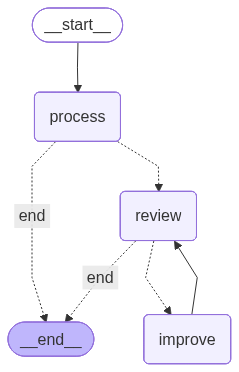

In [30]:
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
result = app.invoke({
    "messages": [HumanMessage(content="Explain neural networks in simple terms")],
    "current_step": "init",
    "iteration": 0,
    "max_iterations": 3,
    "error": None
})

In [32]:
print(f"Total iterations: {result['iteration']}")
print(f"\nFinal response:")
print(result["messages"][-1].content)

Total iterations: 3

Final response:
Review: Rating: 8/10

Feedback:

**Strengths:**

* The response covers the fundamental concepts of neural networks, including basic components, training, backpropagation, regularization techniques, deepening the network, and other architectures.
* The text is well-structured and easy to follow, with clear headings and concise paragraphs.
* The inclusion of a code snippet demonstrates practical application of the concepts.

**Weaknesses:**

* Some sections feel a bit too brief or superficial (e.g., "Regularization Techniques" and "Loss Functions and Optimization Algorithms").
* The response could benefit from more concrete examples or illustrations to help clarify complex concepts.
* There are no visual aids, such as diagrams or flowcharts, to supplement the text and enhance understanding.

**Suggestions for improvement:**

1. Expand on the regularization techniques section by providing a clear explanation of how L1 and dropout regularization work.
2

In [34]:
from typing import TypedDict, Annotated, Literal
from langgraph.graph import StateGraph, END

class State(TypedDict):
    query: str
    query_type: Literal["factual", "creative", "computational"] | None
    result: str

def classify_query(state: State) -> dict:
    """Classify the query type"""
    query = state["query"].lower()
    
    if any(word in query for word in ["calculate", "compute", "math"]):
        qtype = "computational"
    elif any(word in query for word in ["story", "poem", "creative"]):
        qtype = "creative"
    else:
        qtype = "factual"
    
    return {"query_type": qtype}

def route_query(state: State) -> str:
    """Route based on query type"""
    return state["query_type"]  # Returns "factual", "creative", or "computational"

def handle_factual(state: State) -> dict:
    return {"result": f"Factual answer for: {state['query']}"}

def handle_creative(state: State) -> dict:
    return {"result": f"Creative response for: {state['query']}"}

def handle_computational(state: State) -> dict:
    return {"result": f"Computation for: {state['query']}"}

# Build graph
workflow = StateGraph(State)

workflow.add_node("classify", classify_query)
workflow.add_node("factual", handle_factual)
workflow.add_node("creative", handle_creative)
workflow.add_node("computational", handle_computational)

workflow.set_entry_point("classify")

workflow.add_conditional_edges(
    "classify",
    route_query,
    {
        "factual": "factual",
        "creative": "creative",
        "computational": "computational"
    }
)

# All paths lead to END
workflow.add_edge("factual", END)
workflow.add_edge("creative", END)
workflow.add_edge("computational", END)

app = workflow.compile()

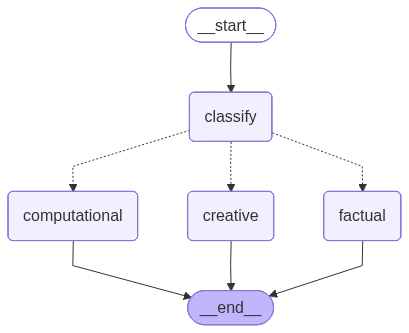

In [35]:
display(Image(app.get_graph().draw_mermaid_png()))

In [36]:
# Test different query types
test_queries = [
    "What is the capital of France?",
    "Write me a short poem about clouds",
    "Calculate 123 * 456"
]

for query in test_queries:
    result = app.invoke({"query": query, "query_type": None, "result": ""})
    print(f"\nQuery: {query}")
    print(f"Type: {result['query_type']}")
    print(f"Result: {result['result']}")


Query: What is the capital of France?
Type: factual
Result: Factual answer for: What is the capital of France?

Query: Write me a short poem about clouds
Type: creative
Result: Creative response for: Write me a short poem about clouds

Query: Calculate 123 * 456
Type: computational
Result: Computation for: Calculate 123 * 456


### Production way of defining graphs

In [48]:
from typing import TypedDict, Annotated, Literal
from operator import add
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage
import logging
import sqlite3

In [38]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [39]:
# State definition
class ProductionState(TypedDict):
    messages: Annotated[list, add]
    user_id: str
    session_id: str
    iteration: Annotated[int, add]
    max_iterations: int
    status: Literal["processing", "success", "error"]
    error_message: str | None
    metadata: dict

In [55]:
# Initialize components
llm = ChatOllama(model="llama3.2", temperature=0.7)

conn = sqlite3.connect("./production.db", check_same_thread=False)
checkpointer = SqliteSaver(conn)

In [50]:
# Node implementations
def process_input(state: ProductionState) -> dict:
    """Main processing node"""
    try:
        logger.info(f"Processing for user: {state['user_id']}")
        
        response = llm.invoke(state["messages"])
        
        return {
            "messages": [response],
            "iteration": 1,
            "status": "processing"
        }
    
    except Exception as e:
        logger.error(f"Error in process_input: {e}")
        return {
            "status": "error",
            "error_message": str(e)
        }

def validate_output(state: ProductionState) -> dict:
    """Validation node"""
    try:
        # Add validation logic
        last_message = state["messages"][-1].content
        
        if len(last_message) < 10:
            return {
                "status": "error",
                "error_message": "Response too short"
            }
        
        return {"status": "success"}
    
    except Exception as e:
        logger.error(f"Error in validate_output: {e}")
        return {
            "status": "error",
            "error_message": str(e)
        }

# Routing logic
def route_next(state: ProductionState) -> str:
    """Determine next step"""
    if state["status"] == "error":
        return "error"
    
    if state["iteration"] >= state["max_iterations"]:
        return "end"
    
    if state["status"] == "success":
        return "end"
    
    return "validate"

In [56]:

# Build graph
workflow = StateGraph(ProductionState)

workflow.add_node("process", process_input)
workflow.add_node("validate", validate_output)

workflow.set_entry_point("process")

workflow.add_conditional_edges(
    "process",
    route_next,
    {
        "validate": "validate",
        "error": END,
        "end": END
    }
)

workflow.add_conditional_edges(
    "validate",
    route_next,
    {
        "end": END,
        "error": END
    }
)

# Compile with checkpointing
app = workflow.compile(checkpointer=checkpointer)

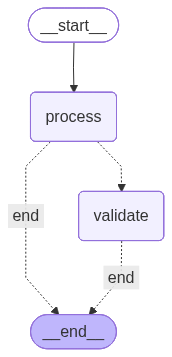

In [57]:
display(Image(app.get_graph().draw_mermaid_png()))

In [58]:
# Usage function
def run_agent(user_id: str, session_id: str, message: str):
    """Run the agent with proper configuration"""
    config = {
        "configurable": {
            "thread_id": f"{user_id}-{session_id}"
        }
    }
    
    initial_state = {
        "messages": [HumanMessage(content=message)],
        "user_id": user_id,
        "session_id": session_id,
        "iteration": 0,
        "max_iterations": 3,
        "status": "processing",
        "error_message": None,
        "metadata": {}
    }
    
    try:
        result = app.invoke(initial_state, config=config)
        
        if result["status"] == "error":
            logger.error(f"Agent failed: {result['error_message']}")
        
        return result
    
    except Exception as e:
        logger.error(f"Unexpected error: {e}")
        raise

In [59]:
# Example usage
result = run_agent(
    user_id="user-123",
    session_id="session-456",
    message="Explain quantum computing"
)

print(f"Status: {result['status']}")
if result['status'] == 'success':
    print(f"Response: {result['messages'][-1].content}")

INFO:__main__:Processing for user: user-123
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Status: success
Response: Quantum Computing is a revolutionary technology that uses the principles of quantum mechanics to perform calculations and operations on data. It's a new paradigm for computing that has the potential to solve problems that are currently unsolvable or require an unfeasible amount of time with classical computers.

**Classical vs Quantum Computing**

In classical computing, bits can only exist in one of two states: 0 or 1. This is known as binary logic. In contrast, quantum computing uses qubits (quantum bits), which can exist in multiple states simultaneously, represented by a combination of 0 and 1. This property, known as superposition, allows qubits to process multiple possibilities at the same time.

Another key concept in quantum computing is entanglement, where two or more qubits become connected in such a way that their properties are correlated, regardless of the distance between them. This enables quantum computers to perform many calculations simultane